In [163]:
import pandas as pd
import os
parent_directory = os.path.dirname(os.getcwd())
#os.chdir(parent_directory)
#print(os.getcwd())
# Load the CSV into a DataFrame
breast_cancer = pd.read_csv('data/Breast_Cancer.csv', header=0, delimiter=',')

# Check the shape of the DataFrame
print("Shape of the DataFrame:", breast_cancer.shape)


Shape of the DataFrame: (4024, 16)


## Preprocessing

In [164]:
# remove spaces and symbols to avoid problems with statsmodel GLM
breast_cancer.columns = [c.lower().strip().replace(' ','_').replace('/','_').replace('-','_') 
                                for c in breast_cancer.columns] 

# change the type of categorical variables into category
categorical_columns = list(breast_cancer.dtypes[breast_cancer.dtypes == 'O'].index.values)
for column in categorical_columns:
    breast_cancer[column] = breast_cancer[column].astype('category')

In [165]:
# change the type of categorical variables into category
categorical_columns = list(breast_cancer.dtypes[breast_cancer.dtypes == 'O'].index.values)
for column in categorical_columns:
    breast_cancer[column] = breast_cancer[column].astype('category')
# Define the custom order for each categorical variable
t_stage_order = ['T1', 'T2', 'T3', 'T4']
n_stage_order = ['N1', 'N2', 'N3']
stage_6_order = ['IIA', 'IIB', 'IIIA', 'IIIB', 'IIIC']
differentiate_order = ['Undifferentiated', 'Poorly differentiated', 'Moderately differentiated', 'Well differentiated']


# Apply the custom order to the categorical variables
breast_cancer['t_stage'] = pd.Categorical(breast_cancer['t_stage'], categories=t_stage_order, ordered=True)
breast_cancer['n_stage'] = pd.Categorical(breast_cancer['n_stage'], categories=n_stage_order, ordered=True)
breast_cancer['6th_stage'] = pd.Categorical(breast_cancer['6th_stage'], categories=stage_6_order, ordered=True)
breast_cancer['differentiate'] = pd.Categorical(breast_cancer['differentiate'], categories=differentiate_order, ordered=True)

# Convert to numeric codes
breast_cancer['t_stage'] = breast_cancer['t_stage'].cat.codes
breast_cancer['n_stage'] = breast_cancer['n_stage'].cat.codes
breast_cancer['6th_stage'] = breast_cancer['6th_stage'].cat.codes
breast_cancer['differentiate'] = breast_cancer['differentiate'].cat.codes

# Eliminate columns   
breast_cancer = breast_cancer.drop(columns=['grade'])

### Feature Extraction

In [166]:
# Feature Extraction
#breast_cancer['survival_50'] = breast_cancer['survival_months'].apply(lambda x: 1 if x >= 50 else 0)
#breast_cancer = breast_cancer.drop(columns=['survival_months'])

breast_cancer['node_ratio'] = (breast_cancer['regional_node_positive']+0.1)/(breast_cancer['regional_node_examined']+0.1)
breast_cancer = breast_cancer.drop(columns=['regional_node_examined'])


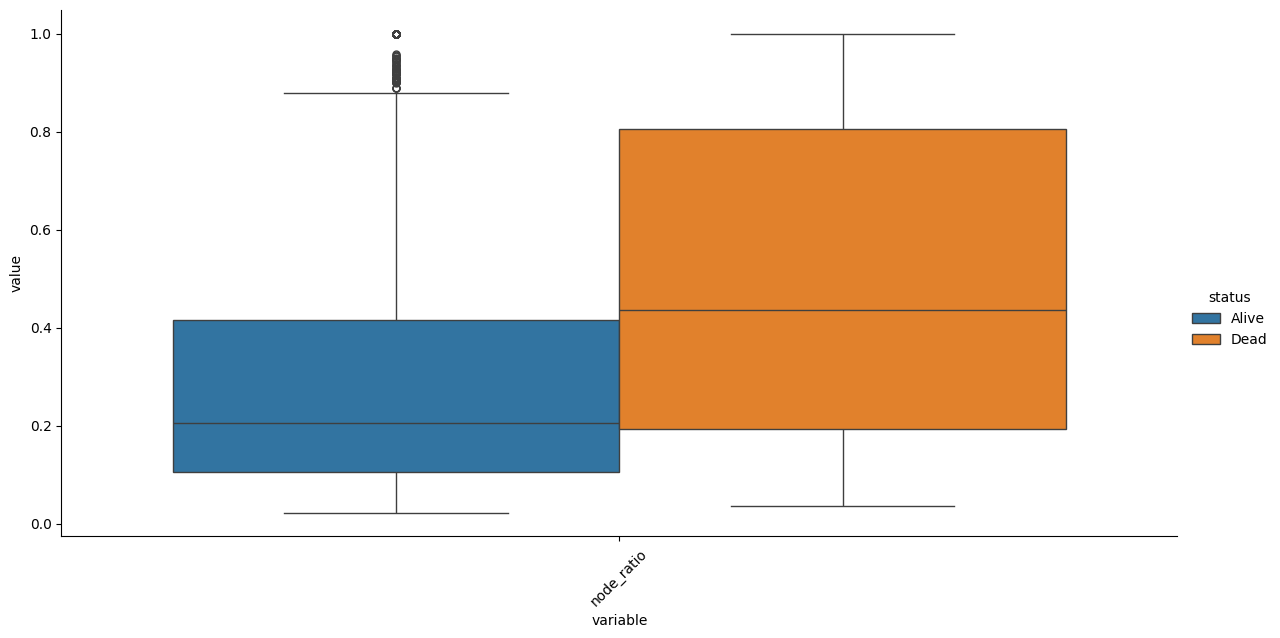

In [167]:
# boxplot of node_ratio categorized by status
import seaborn as sns
import matplotlib.pyplot as plt
def boxplot(df, target_variable, num_vars):
    # Melt the DataFrame
    df_melted = df.melt(id_vars=target_variable, value_vars=num_vars)

    # Create a box plot categorized by the categorical variable on the y-axis
    sns.catplot(x='variable', y='value', hue=target_variable, kind='box', data=df_melted, height=6, aspect=2)

    # Rotate x-axis labels for better readability if needed
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()

boxplot(breast_cancer, 'status', ['node_ratio'])


In [168]:
breast_cancer.head()

,age,race,marital_status,t_stage,n_stage,6th_stage,differentiate,a_stage,tumor_size,estrogen_status,progesterone_status,regional_node_positive,survival_months,status,node_ratio
0,68,White,Married,0,0,0,1,Regional,4,Positive,Positive,1,60,Alive,0.045643
1,50,White,Married,1,1,2,2,Regional,35,Positive,Positive,5,62,Alive,0.361702
2,58,White,Divorced,2,2,4,2,Regional,63,Positive,Positive,7,75,Alive,0.503546
3,58,White,Married,0,0,0,1,Regional,18,Positive,Positive,1,84,Alive,0.523810
4,47,White,Married,1,0,1,1,Regional,41,Positive,Positive,1,50,Alive,0.354839


In [169]:
#breast_cancer = breast_cancer.drop(["regional_node_examined", "regional_node_positive", "a_stage", "estrogen_status", "progesterone_status"], axis=1)

breast_cancer.shape

(4024, 15)

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_columns = list(breast_cancer.dtypes[breast_cancer.dtypes != 'category'].index.values)
breast_cancer_numeric = breast_cancer[numeric_columns]
"""plt.figure(figsize=(20, 20))
sns.heatmap(breast_cancer_numeric.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()"""

"plt.figure(figsize=(20, 20))\nsns.heatmap(breast_cancer_numeric.corr(), annot=True, cmap='coolwarm', fmt='.2f')\nplt.show()"

In [171]:
# type of each column
breast_cancer.dtypes

age                          int64
race                      category
marital_status            category
t_stage                       int8
n_stage                       int8
6th_stage                     int8
differentiate                 int8
a_stage                   category
tumor_size                   int64
estrogen_status           category
progesterone_status       category
regional_node_positive       int64
survival_months              int64
status                    category
node_ratio                 float64
dtype: object

## PCA

['age', 't_stage', 'n_stage', '6th_stage', 'differentiate', 'tumor_size', 'regional_node_positive', 'survival_months', 'node_ratio']
[0.50421031 0.90183195 0.9756246  0.99887304 0.99941386 0.99976681
 0.99992678 0.9999702  1.        ]


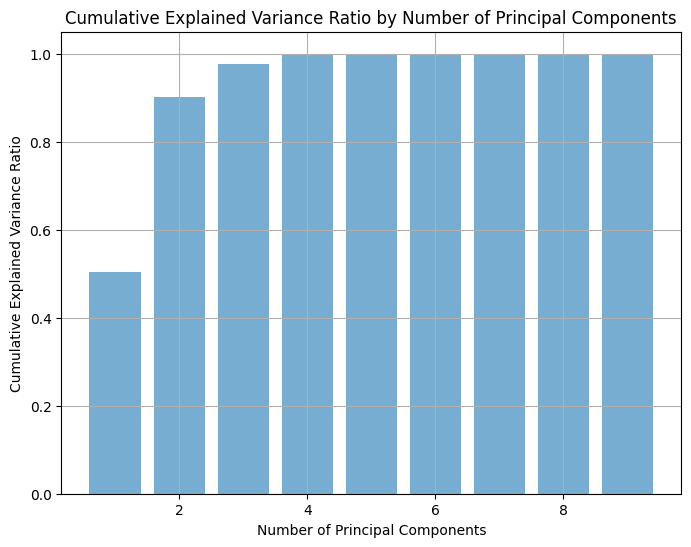

In [172]:
from sklearn.decomposition import PCA
# get all variables that are not categorical
categorical_columns =breast_cancer.dtypes[breast_cancer.dtypes == 'category'].index.values
numerical_columns = [c for c in breast_cancer.columns if c not in categorical_columns]
print(numerical_columns)
breast_cancer_numeric = breast_cancer[numeric_columns]
pca = PCA()
pca.fit(breast_cancer_numeric)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()
print(cumulative_variance)
# Plot histogram
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(cumulative_variance) + 1), cumulative_variance, alpha=0.6)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Number of Principal Components')
plt.grid(True)
plt.show()

In [173]:
# Apply PCA
pca = PCA(n_components=4)
breast_cancer_pca = pca.fit_transform(breast_cancer_numeric)
breast_cancer_pca = pd.DataFrame(breast_cancer_pca, columns=['PC1', 'PC2', 'PC3', 'PC4'])
breast_cancer_pca.head()

,PC1,PC2,PC3,PC4
0,-0.758957,-29.465813,-12.782812,-2.287294
1,10.414519,0.541403,3.846310,0.549788
2,10.008254,31.183061,-5.414337,1.267332
3,-16.875250,-6.512724,-3.553803,-2.277689
4,23.608340,1.013767,6.843866,-4.262440


In [174]:
# Concatenate the PCA DataFrame with the categorical variables
breast_cancer_pca = pd.concat([breast_cancer_pca, breast_cancer[["survival_months","node_ratio"]]], axis=1)
breast_cancer = pd.concat([breast_cancer_pca, breast_cancer[categorical_columns]], axis=1)
breast_cancer.head()

,PC1,PC2,PC3,PC4,survival_months,node_ratio,race,marital_status,a_stage,estrogen_status,progesterone_status,status
0,-0.758957,-29.465813,-12.782812,-2.287294,60,0.045643,White,Married,Regional,Positive,Positive,Alive
1,10.414519,0.541403,3.846310,0.549788,62,0.361702,White,Married,Regional,Positive,Positive,Alive
2,10.008254,31.183061,-5.414337,1.267332,75,0.503546,White,Divorced,Regional,Positive,Positive,Alive
3,-16.875250,-6.512724,-3.553803,-2.277689,84,0.523810,White,Married,Regional,Positive,Positive,Alive
4,23.608340,1.013767,6.843866,-4.262440,50,0.354839,White,Married,Regional,Positive,Positive,Alive


### Dataset Splits

In [175]:
from sklearn.model_selection import train_test_split

X = breast_cancer.loc[:, breast_cancer.columns != 'status']
y = breast_cancer['status']
# We should split data into training validation and test sets (64%, 16%, 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [176]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


def preprocessing(X, y):
    print('Original shape:{}'.format(X.shape))
    categorical_columns =X.dtypes[X.dtypes == 'category'].index.values
    
    # Apply one hot encoding to categorical variables
    for column in categorical_columns:
        X_one_hot = pd.get_dummies(X[column], prefix=column)
        X = X.merge(X_one_hot,left_index=True,right_index=True)
        X = X.drop(columns=[column])
    
    # Drop missings
    X=X.dropna()
    y=y[X.index]
    print('New shape:{}'.format(X.shape))
    return X, y


X_train, y_train = preprocessing(X_train,y_train)
X_test, y_test, = preprocessing(X_test,y_test)



Original shape:(2615, 11)
New shape:(2615, 20)
Original shape:(1409, 11)
New shape:(1409, 20)


### Oversampling

In [177]:
from imblearn.over_sampling import SMOTE
# Apply Oversampling to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

### Modeling

In [178]:
#!pip install imblearn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.naive_bayes import GaussianNB

np.random.seed(42)

# Define the models and their hyperparameter grids
logreg = LogisticRegressionCV(Cs=20, random_state=1, cv = 10, scoring = 'accuracy', multi_class='multinomial')
logreg.fit(X_train_resampled, y_train_resampled)
avg_crossval_scores = logreg.scores_['Dead'].mean(axis=0)
idx = np.argmax(avg_crossval_scores)
best_C = logreg.Cs_[idx]

models = {
    'Logistic Regression': (LogisticRegression(C=best_C), {'penalty': ['l1', 'l2'],'class_weight': [None,'balanced'], 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}),
    'SVM': (SVC(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],'class_weight': ['balanced']}),
    'Gradient Boosting': (GradientBoostingClassifier(), {'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.01, 0.001],}),
    'Random Forest': (RandomForestClassifier(), {'criterion': ['gini', 'entropy', 'log_loss'],'n_estimators': [100, 200, 300], 'max_depth': [5, 10],'class_weight': [None, 'balanced']}),  
}

# Define a custom scoring function to calculate precision, recall, F1-score
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, pos_label='Dead'),
    'recall': make_scorer(recall_score, pos_label='Dead'),
    'f1_score': make_scorer(f1_score, pos_label='Dead')
}

# Perform cross-validation and hyperparameter tuning for each model
results = {}
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring, refit='f1_score')
    grid_search.fit(X_train_resampled, y_train_resampled)
    #grid_search.fit(X_train_resampled, y_train_resampled)
    
    # Get the mean cross-validated scores for each metric
    cv_results = grid_search.cv_results_
    cv_scores = {
        'CV Precision': cv_results['mean_test_precision'][grid_search.best_index_],
        'CV Recall': cv_results['mean_test_recall'][grid_search.best_index_],
        'CV F1-score': cv_results['mean_test_f1_score'][grid_search.best_index_]
    }
    # Evaluate the model on the training data
    best_model = grid_search.best_estimator_
    y_val_pred = best_model.predict(X_val)
    
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    validation_scores = {
        'Validation Precision': precision_score(y_val, y_val_pred, pos_label='Dead'),
        'Validation Recall': recall_score(y_val, y_val_pred, pos_label='Dead'),
        'Validation F1-score': f1_score(y_val, y_val_pred, pos_label='Dead')
    }
    
    results[model_name] = {
        'Best Hyperparameters': grid_search.best_params_,
        **cv_scores,
        **validation_scores,
        'Cross Validation Errors': cv_results['std_test_accuracy'][grid_search.best_index_]
    }
    
# Create a dataframe to store the results
df_results = pd.DataFrame(results).transpose()
df_results.index.name = 'Model'


C:\Users\JaIk194\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\JaIk194\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/

In [179]:
df_results['Best Hyperparameters']["Random Forest"]

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'n_estimators': 100}

In [180]:
df_results

,Best Hyperparameters,Precision,Recall,F1-score,Training Precision,Training Recall,Training F1-score,Validation Errors
Model,,,,,,,,
Logistic Regression,"{'class_weight': None, 'penalty': 'l1', 'solve...",0.953628,0.808672,0.847997,0.960082,0.850023,0.901706,0.118237
SVM,"{'C': 10, 'class_weight': 'balanced', 'kernel'...",0.905435,0.773419,0.830749,0.920751,0.800181,0.856242,0.032597
Gradient Boosting,"{'learning_rate': 0.1, 'n_estimators': 100}",0.947581,0.850395,0.885612,0.961938,0.88174,0.920095,0.077707
Random Forest,"{'class_weight': 'balanced', 'criterion': 'gin...",0.943161,0.868998,0.900005,0.984863,0.91391,0.948061,0.051404


### Random Forest

Random Forest Classifier - Test Results
---------------------------------
Accuracy: 0.8999
Precision: 0.6851
Recall: 0.5962
F1-score: 0.6375
---------------------------------
Confusion Matrix:
Predicted Value  Alive  Dead
True Value                  
Alive             1144    57
Dead                84   124


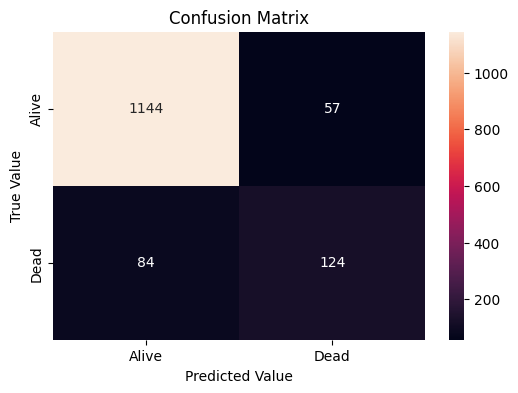

In [146]:
from sklearn.metrics import accuracy_score, confusion_matrix
# Define the best hyperparameters for Random Forest
best_rf_params = {'class_weight': 'balanced', 'criterion': 'gini','max_depth': 10, 'n_estimators': 200}

# Create and fit the best Random Forest model
best_rf_model = RandomForestClassifier(**best_rf_params)

# Fit the model and obtain the training and validation loss
best_rf_model.fit(X_train_resampled, y_train_resampled)

# Use the fitted model to make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the performance of the model on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Dead')
recall = recall_score(y_test, y_pred, pos_label='Dead')
f1 = f1_score(y_test, y_pred, pos_label='Dead')
confusion_mat = confusion_matrix(y_test, y_pred)

# Define class labels
class_labels = ['Alive', 'Dead']

# Create a labeled confusion matrix with indicators
confusion_mat_labeled = pd.DataFrame(confusion_mat, index=class_labels, columns=class_labels)
confusion_mat_labeled.index.name = 'True Value'
confusion_mat_labeled.columns.name = 'Predicted Value'

# Print the performance metrics and labeled confusion matrix
print("Random Forest Classifier - Test Results")
print("---------------------------------")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("---------------------------------")
print("Confusion Matrix:")
print(confusion_mat_labeled)


# Plot the labeled confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat_labeled, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show();

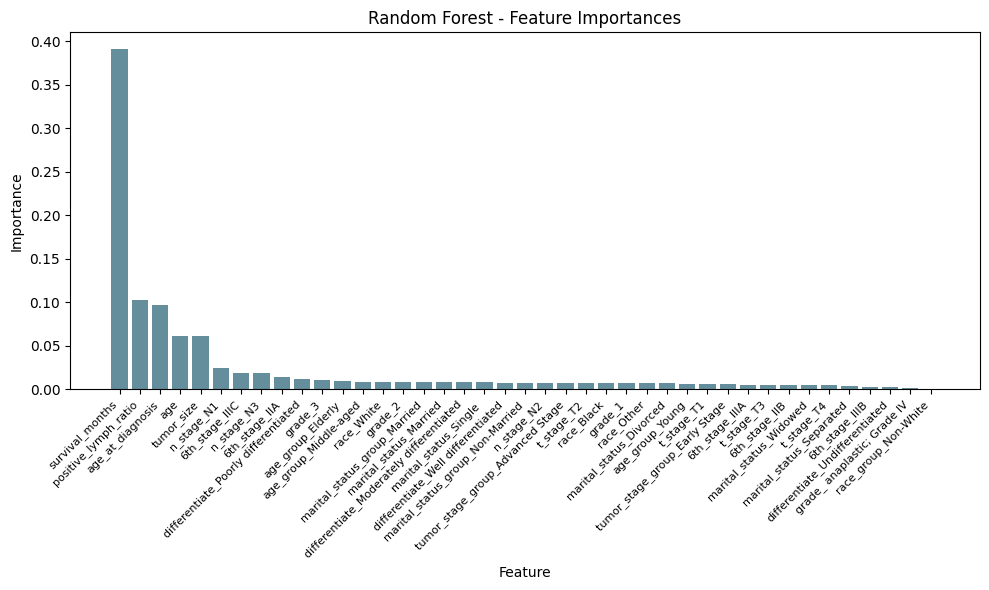

In [ ]:
# Get feature importances from the best Random Forest model
feature_importances = best_rf_model.feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]

# Get the names of the features
feature_names = X_train.columns[sorted_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), sorted_feature_importances, color='#648E9C')
plt.xticks(range(len(feature_importances)), feature_names, rotation=45, ha='right', fontsize=8)
plt.title('Random Forest - Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show();